In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
import shutil

In [4]:
#dataset paths
weather_dataset = "/content/drive/MyDrive/Dataset/Dataset"
split_dataset_path = "/content/drive/MyDrive/Dataset/Split_Dataset"

# split folders
os.makedirs(os.path.join(split_dataset_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(split_dataset_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(split_dataset_path, 'test'), exist_ok=True)

# Ratios for train/val/test split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Loop through each weather folder
for weather in os.listdir(weather_dataset):
    weather_path = os.path.join(weather_dataset, weather)

    if not os.path.isdir(weather_path):
        continue  # Skip if not a folder

    # List all image files
    images = [f for f in os.listdir(weather_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Split into train, val, test
    train_files, test_files = train_test_split(images, test_size=test_ratio, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_ratio/(train_ratio + val_ratio), random_state=42)

    # Create folders for current weather type
    os.makedirs(os.path.join(split_dataset_path, 'train', weather), exist_ok=True)
    os.makedirs(os.path.join(split_dataset_path, 'val', weather), exist_ok=True)
    os.makedirs(os.path.join(split_dataset_path, 'test', weather), exist_ok=True)

    # Copy images to their respective split folders
    for f in train_files:
        shutil.copyfile(os.path.join(weather_path, f), os.path.join(split_dataset_path, 'train', weather, f))

    for f in val_files:
        shutil.copyfile(os.path.join(weather_path, f), os.path.join(split_dataset_path, 'val', weather, f))

    for f in test_files:
        shutil.copyfile(os.path.join(weather_path, f), os.path.join(split_dataset_path, 'test', weather, f))

print(" splitting completed!")

 splitting completed!


In [5]:
# Set parameters
plt.rc('figure', autolayout=True)
plt.rc('image', cmap='magma')
image_size = 128

# Define kernel
kernel = tf.constant([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]], dtype=tf.float32)
kernel = tf.expand_dims(tf.repeat(tf.expand_dims(kernel, axis=-1), 3, axis=-1), axis=-1)

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.GaussianNoise(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

In [7]:
df = "/content/drive/MyDrive/Dataset/Split_Dataset"
# Get weather classes and create label map
weather_classes = sorted(os.listdir(weather_dataset))
weather_classes = [wc for wc in weather_classes if os.path.isdir(os.path.join(weather_dataset, wc))]
label_map = {weather_class: idx for idx, weather_class in enumerate(weather_classes)}

# Now define your load_weather_data function
def load_weather_data(split, apply_augmentation=False):
    images = []
    labels = []
    split_path = os.path.join(df, split)

    for label in weather_classes:
        folder = os.path.join(split_path, label)
        img_names = os.listdir(folder)

        for img_name in img_names:
            img_path = os.path.join(folder, img_name)
            try:
                img = tf.io.read_file(img_path)
                img = tf.image.decode_jpeg(img, channels=3)

                # Rest of your function remains the same...



                # Better resizing with anti-aliasing
                img = tf.image.resize(img, [image_size, image_size],
                                      method='bicubic', antialias=True)

                # Normalize to [-1,1] range (better for CNNs)
                img = tf.image.convert_image_dtype(img, tf.float32)
                img = (img - 0.5) * 2.0  # Scale to [-1, 1]

                if apply_augmentation:
                    # More sophisticated augmentation
                    img = tf.image.random_brightness(img, 0.2)
                    img = tf.image.random_contrast(img, 0.8, 1.2)
                    img = tf.image.random_saturation(img, 0.8, 1.2)
                    img = tf.image.random_hue(img, 0.1)
                    img = tf.image.random_flip_left_right(img)
                    img = tf.image.random_flip_up_down(img)
                    # Random rotation and zoom
                    if tf.random.uniform(()) > 0.5:
                        img = tf.image.rot90(img)
                    img = tf.image.random_crop(img, size=[image_size-10, image_size-10, 3])
                    img = tf.image.resize(img, [image_size, image_size])

                images.append(img)
                labels.append(label_map[label])

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue

    return tf.stack(images), tf.convert_to_tensor(labels, dtype=tf.int32)

In [8]:
# Load datasets
X_train, y_train = load_weather_data('train')
X_val, y_val = load_weather_data('val')
X_test, y_test = load_weather_data('test')

# Print dataset shapes
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Error processing /content/drive/MyDrive/Dataset/Split_Dataset/train/snow/0982.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Error processing /content/drive/MyDrive/Dataset/Split_Dataset/test/snow/0982.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Training set: (1422, 128, 128, 3) (1422,)
Validation set: (373, 128, 128, 3) (373,)
Test set: (378, 128, 128, 3) (378,)


In [9]:
# Define convolution function (modified for RGB with single filter)
def convolution(image):
    # Convert image to float32, expand dimensions for batch
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)  # Shape becomes [1, H, W, 3]

    # Apply convolution with your predefined kernel
    image_filter = tf.nn.conv2d(
        input=image,
        filters=kernel,  # Using your [3,3,3,3] kernel
        strides=1,
        padding='SAME'
    )

    return image_filter  # Output shape [1, H, W, 1]

In [10]:
image_filters = []
for img in X_train:
    processed_image = convolution(img)
    image_filters.append(processed_image)

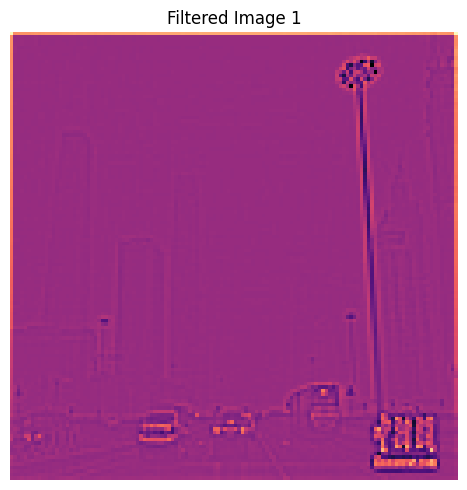

In [11]:
# Plot only one filtered image from the dataset
plt.figure(figsize=(5, 5))
plt.imshow(tf.squeeze(image_filters[0]))
plt.axis('off')
plt.title('Filtered Image 1')
plt.show()

In [12]:
# Define activation function (ReLU) - unchanged from your original
def activation(image_filter):
    # Apply ReLU activation function to the output of convolution
    activated_image = tf.nn.relu(image_filter)
    return activated_image

In [13]:
# Apply ReLU to convolved images (using your variable names)
activated_images = []
for img_filter in image_filters:  # 'image_filters' from your convolution step
    activated_image = activation(img_filter)
    activated_images.append(activated_image)

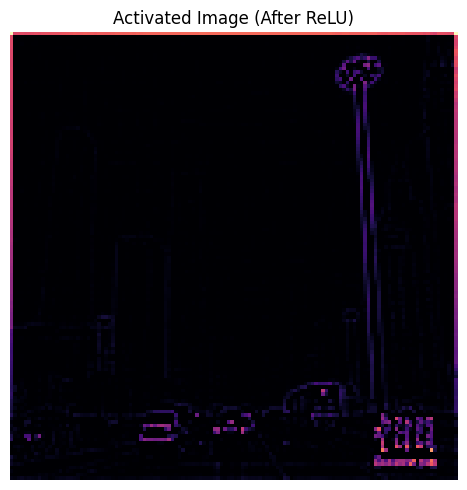

In [14]:

# Plot one activated image - identical to your original, just with RGB adaptation
plt.figure(figsize=(5, 5))
plt.imshow(tf.squeeze(activated_images[0]), cmap='magma')  # Using magma colormap
plt.axis('off')
plt.title('Activated Image (After ReLU)')  # Same title style
plt.show()

In [15]:
def pooling(image_detect):
    # Apply max pooling with your specified parameters
    pooled_image = tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='SAME'
    )(image_detect)
    return pooled_image

In [16]:
pooled_images = []
for img_detect in activated_images:  # 'activated_images' from ReLU step
    pooled_image = pooling(img_detect)
    pooled_images.append(pooled_image)

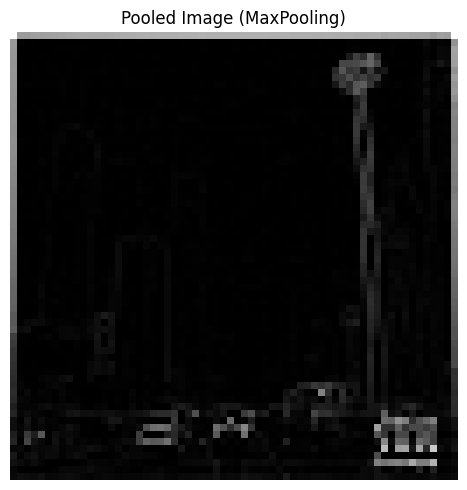

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(tf.squeeze(pooled_images[0]), cmap='gray')  # Changed to 'gray' for single-channel
plt.axis('off')
plt.title('Pooled Image (MaxPooling)')  # Kept your title style
plt.show()

In [18]:
# Define flattening function (unchanged structure)
def flatten(image_pooled):
    # Flatten while preserving batch dimension
    flattened_image = tf.keras.layers.Flatten()(image_pooled)
    return flattened_image

# Apply flattening to pooled images (using your variable names)
flattened_images = []
for img_pooled in pooled_images:  # 'pooled_images' from MaxPooling step
    flattened_img = flatten(img_pooled)
    flattened_images.append(flattened_img)

# Verification print (optional)
print("Shape before flattening:", pooled_images[0].shape)  # Should be (1, H/2, W/2, 3)
print("Shape after flattening:", flattened_images[0].shape) # Should be (1, (H/2 * W/2 * 3))

Shape before flattening: (1, 64, 64, 1)
Shape after flattening: (1, 4096)


In [21]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
def build_vgg19_model(image_size, num_classes):
    # Load pre-trained VGG19 (without top layers)
    base_model = VGG19(
        input_shape=(image_size, image_size, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model
    base_model.trainable = False

    # Build custom head with MaxPooling
    inputs = layers.Input(shape=(image_size, image_size, 3))
    x = base_model(inputs, training=False)

    # Your original MaxPooling approach
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Flatten()(x)

    # Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [23]:

# ====================== MODEL COMPILATION ======================
model = build_vgg19_model(image_size, len(weather_classes))

optimizer = optimizers.Adam(learning_rate=0.0001)  # Lower LR for fine-tuning

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ====================== CALLBACKS ======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_maxpool.h5', save_best_only=True)
]


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:

# ====================== TRAINING ======================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3651 - loss: 27.0168

45/45 ━━━━━━━━━━━━━━━━━━━━ 514s 11s/step - accuracy: 0.3658 - loss: 26.9137 - val_accuracy: 0.6220 - val_loss: 8.0405
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4855 - loss: 15.7352

45/45 ━━━━━━━━━━━━━━━━━━━━ 543s 11s/step - accuracy: 0.4861 - loss: 15.7067 - val_accuracy: 0.6783 - val_loss: 6.3315
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5903 - loss: 10.3842

45/45 ━━━━━━━━━━━━━━━━━━━━ 494s 11s/step - accuracy: 0.5903 - loss: 10.3818 - val_accuracy: 0.7078 - val_loss: 5.4364
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6402 - loss: 7.9213

45/45 ━━━━━━━━━━━━━━━━━━━━ 495s 11s/step - accuracy: 0.6402 - loss: 7.9189 - val_accuracy: 0.7319 - val_loss: 4.8597
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6255 - loss: 7.3486

45/45 ━━━━━━━━━━━━━━━━━━━━ 452s 10s/step - accuracy: 0.6260 - loss: 7.3323 - val_accuracy: 0.7694 - val_loss: 4.3566
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7134 - loss: 5.2455

45/45 ━━━━━━━━━━━━━━━━━━━━ 550s 11s/step - accuracy: 0.7138 - loss: 5.2308 - val_accuracy: 0.7775 - val_loss: 3.8941
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7446 - loss: 4.4814

45/45 ━━━━━━━━━━━━━━━━━━━━ 493s 11s/step - accuracy: 0.7447 - loss: 4.4714 - val_accuracy: 0.7802 - val_loss: 3.6538
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7622 - loss: 3.5654

45/45 ━━━━━━━━━━━━━━━━━━━━ 451s 10s/step - accuracy: 0.7624 - loss: 3.5622 - val_accuracy: 0.7909 - val_loss: 3.3984
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7963 - loss: 2.7839

45/45 ━━━━━━━━━━━━━━━━━━━━ 554s 11s/step - accuracy: 0.7964 - loss: 2.7837 - val_accuracy: 0.7936 - val_loss: 3.3222
Epoch 10/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7958 - loss: 2.4423

45/45 ━━━━━━━━━━━━━━━━━━━━ 495s 11s/step - accuracy: 0.7954 - loss: 2.4488 - val_accuracy: 0.8043 - val_loss: 3.0874
Epoch 11/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7993 - loss: 2.0662

45/45 ━━━━━━━━━━━━━━━━━━━━ 500s 11s/step - accuracy: 0.7996 - loss: 2.0667 - val_accuracy: 0.8097 - val_loss: 3.0144
Epoch 12/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 501s 11s/step - accuracy: 0.8285 - loss: 1.7741 - val_accuracy: 0.8043 - val_loss: 3.0567
Epoch 13/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8291 - loss: 1.6724

45/45 ━━━━━━━━━━━━━━━━━━━━ 451s 10s/step - accuracy: 0.8291 - loss: 1.6717 - val_accuracy: 0.8150 - val_loss: 2.8507
Epoch 14/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8683 - loss: 1.2604

45/45 ━━━━━━━━━━━━━━━━━━━━ 492s 11s/step - accuracy: 0.8682 - loss: 1.2608 - val_accuracy: 0.8284 - val_loss: 2.7802
Epoch 15/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8500 - loss: 1.4811

45/45 ━━━━━━━━━━━━━━━━━━━━ 502s 11s/step - accuracy: 0.8502 - loss: 1.4803 - val_accuracy: 0.8284 - val_loss: 2.6319
Epoch 16/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8680 - loss: 1.2513

45/45 ━━━━━━━━━━━━━━━━━━━━ 502s 11s/step - accuracy: 0.8680 - loss: 1.2496 - val_accuracy: 0.8311 - val_loss: 2.6148
Epoch 17/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8642 - loss: 1.0138

45/45 ━━━━━━━━━━━━━━━━━━━━ 501s 11s/step - accuracy: 0.8645 - loss: 1.0124 - val_accuracy: 0.8445 - val_loss: 2.5937
Epoch 18/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 451s 10s/step - accuracy: 0.8692 - loss: 1.1223 - val_accuracy: 0.8472 - val_loss: 2.6058
Epoch 19/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9113 - loss: 0.7011

45/45 ━━━━━━━━━━━━━━━━━━━━ 446s 10s/step - accuracy: 0.9112 - loss: 0.7013 - val_accuracy: 0.8445 - val_loss: 2.5375
Epoch 20/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8890 - loss: 0.8147

45/45 ━━━━━━━━━━━━━━━━━━━━ 553s 11s/step - accuracy: 0.8891 - loss: 0.8138 - val_accuracy: 0.8445 - val_loss: 2.4797
Epoch 21/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8994 - loss: 0.6465

45/45 ━━━━━━━━━━━━━━━━━━━━ 502s 11s/step - accuracy: 0.8996 - loss: 0.6458 - val_accuracy: 0.8499 - val_loss: 2.4012
Epoch 22/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 502s 11s/step - accuracy: 0.9114 - loss: 0.6921 - val_accuracy: 0.8472 - val_loss: 2.4289
Epoch 23/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 500s 11s/step - accuracy: 0.9186 - loss: 0.5897 - val_accuracy: 0.8472 - val_loss: 2.4207
Epoch 24/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 502s 11s/step - accuracy: 0.9298 - loss: 0.4455 - val_accuracy: 0.8472 - val_loss: 2.4160
Epoch 25/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 446s 10s/step - accuracy: 0.9364 - loss: 0.4786 - val_accuracy: 0.8472 - val_loss: 2.4283
Epoch 26/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 551s 11s/step - accuracy: 0.9297 - loss: 0.4810 - val_accuracy: 0.8552 - val_loss: 2.4125


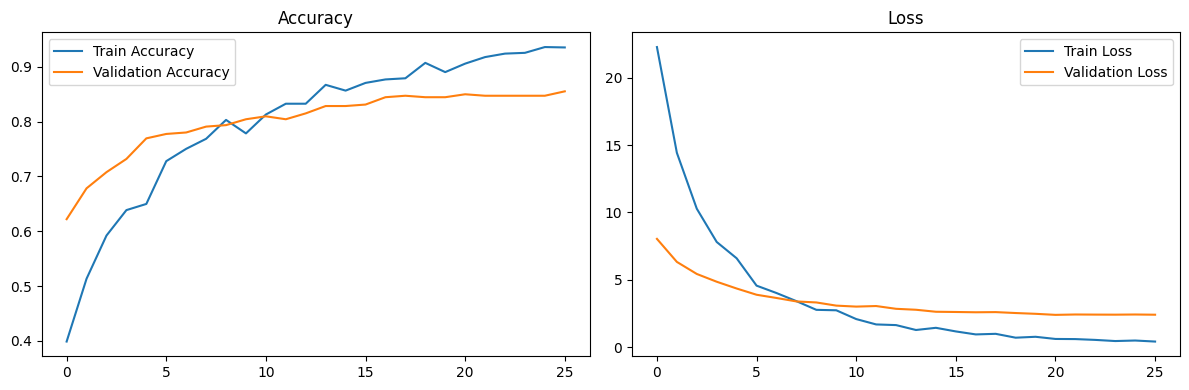

In [26]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [27]:
# Test evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - accuracy: 0.8766 - loss: 1.5899

Test Accuracy: 0.8624


In [30]:
model.save('/content/drive/MyDrive/Dataset/weather_genre_model.keras')

In [31]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Dataset/weather_genre_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [35]:
from google.colab import files
import io
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [37]:

# Define the weather_genre_map
weather_genre_map = {
    "rainy": ["jazz", "blues", "lofi"],
    "snow": ["acoustic", "classical", "ambient"],
    "rainbow": ["indie pop", "synthwave", "electronic"],
    "rime": ["chillout", "neo-classical", "dream pop"],
    "lightning": ["rock", "electro", "drum and bass"],
    "hail": ["metal", "industrial", "techno"],
    "glaze": ["trip-hop", "deep house", "minimal"],
    "frost": ["instrumental", "piano", "downtempo"],
    "fogsmog": ["ambient", "chillstep", "lofi hip hop"]
}

In [40]:

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/weather_genre_model.keras')

# Function to preprocess the image and make prediction
def preprocess_and_predict(image_path):
    # Load the image
    img = Image.open(image_path).convert('RGB')

    # Resize the image to the size used during training
    img = img.resize((image_size, image_size), Image.Resampling.LANCZOS)

    # Convert the image to a numpy array
    img_array = np.array(img)

    # Normalize the image (scale to [-1, 1] range)
    img_array = (img_array / 255.0) * 2 - 1  # Scale to [-1, 1]

    # Expand dimensions to match the input shape expected by the model (batch size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    predictions = model.predict(img_array)

    # Get the index of the class with the highest probability
    predicted_class_idx = np.argmax(predictions)

    # Get the weather class name
    predicted_weather = weather_classes[predicted_class_idx]

    # Get the corresponding music genres
    predicted_genres = weather_genre_map.get(predicted_weather, ["No genres available"])

    return predicted_weather, predicted_genres, img_array

In [41]:

# Upload the image
uploaded = files.upload()

image_path = next(iter(uploaded))

# Make the prediction
predicted_weather, predicted_genres, img_array = preprocess_and_predict(image_path)

Saving upload.jpeg to upload (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


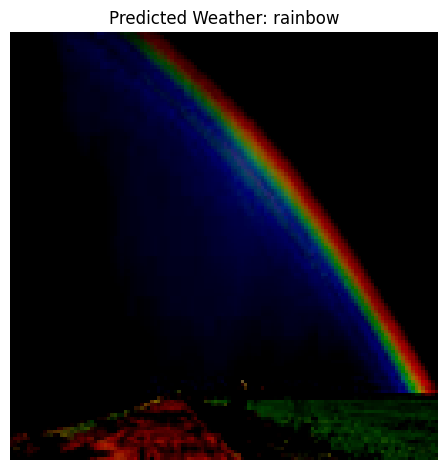

Predicted Weather: rainbow
Suggested Music Genres: indie pop, synthwave, electronic


In [42]:

# Display the image and the predicted weather and genres
plt.imshow(img_array[0])
plt.axis('off')
plt.title(f"Predicted Weather: {predicted_weather}")
plt.show()

print(f"Predicted Weather: {predicted_weather}")
print(f"Suggested Music Genres: {', '.join(predicted_genres)}")

In [44]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


In [45]:
import streamlit as st

In [47]:
image_size = 128

# Label map (match your training)
label_map = {
    "fogsmog": 0, "frost": 1, "glaze": 2, "hail": 3,
    "lightning": 4, "rainbow": 5, "rainy": 6, "rime": 7, "snow": 8
}
label_map = {v: k for k, v in label_map.items()}  # Reverse it

# Genre mapping
weather_genre_map = {
    "rainy": ["jazz", "blues", "lofi"],
    "snow": ["acoustic", "classical", "ambient"],
    "rainbow": ["indie pop", "synthwave", "electronic"],
    "rime": ["chillout", "neo-classical", "dream pop"],
    "lightning": ["rock", "electro", "drum and bass"],
    "hail": ["metal", "industrial", "techno"],
    "glaze": ["trip-hop", "deep house", "minimal"],
    "frost": ["instrumental", "piano", "downtempo"],
    "fogsmog": ["ambient", "chillstep", "lofi hip hop"]
}

# Load the model (adjust path if needed)
model_path = 'weather_genre_model.keras'
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/weather_genre_model.keras')

# =================== UI ===================
st.title("🌦️ Weather-to-Music Genre Classifier 🎧")

uploaded_file = st.file_uploader("Upload a weather image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess
    img = image.resize((image_size, image_size), Image.Resampling.LANCZOS)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array = (img_array - 0.5) * 2.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)
    predicted_weather = label_map[predicted_label]
    genres = weather_genre_map.get(predicted_weather, ["No genre found"])

    # Display result
    st.subheader(f"🌀 Detected Weather: `{predicted_weather.capitalize()}`")
    st.markdown("🎵 **Recommended Genres:**")
    for genre in genres:
        st.markdown(f"- {genre}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-04-17 13:52:12.867 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 13:52:12.995 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-17 13:52:12.996 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 13:52:12.998 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 13:52:12.999 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-17 13:52:13.000 